<a href="https://colab.research.google.com/github/89feiyang/Deep-Learning-AI/blob/master/%E8%BF%81%E7%A7%BB%E5%AD%A6%E4%B9%A0_pytorch_123_com%3DThirdSection%3DTransferLearning%3D__1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 本文是对蜜蜂和蚂蚁的迁移学习代码
此文件已经成功调试 20211112

## 1.导入相关的包

In [17]:
from __future__ import print_function, division  #是为了在老版本的python中兼顾新特性的一种方法,避免不兼容

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler  #导入学习率函数
import numpy as np
import torchvision  #导入数据集
from torchvision import datasets, models, transforms  
import matplotlib.pyplot as plt
import time
import os
import copy  # 拷贝

# import sys #sys模块包含了与Python解释器和它的环境有关的函数，这句话也可以不要
from google.colab import drive
drive.mount('/content/drive') #授权GoogleDrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# sys.path.append('https://drive.google.com/drive/folders/1QuhlA4M-HkMXVXEzR7LV7VAF1OQElBP4?usp=sharing') # 此为你的自定义模块的存储路径 

# plt.ion()   # interactive mode 交互式窗口，因为在plt.show()之后，程序会暂停，使用plt.ion()程序会继续往下运行

# 2.加载数据集

In [ ]:
# 训练集数据扩充和归一化
# 在验证集上仅需要归一化
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), #随机裁剪一个area然后再resize
        transforms.RandomHorizontalFlip(), #随机水平翻转
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
data_dir='/content/drive/MyDrive/Colab Notebooks/hymenoptera_data' # 输入文件地址，这里一定要用复制路径，不然会出错

In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
          data_transforms[x])
          for x in ['train', 'val']}  #{}表示字典，这句话的意思是从train和val中选择x

In [23]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=6, #下载image_datasets,该接口主要用来将自定义的数据读取接口的输出或者PyTorch已有的数据读取接口的输入按照batch size封装成Tensor，后续只需要再包装成Variable即可作为模型的输入，因此该接口有点承上启下的作用
            shuffle=True, num_workers=4)
            for x in ['train', 'val']}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [24]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#3. 可视化部分图像数据
可视化部分训练图像，以便了解数据膨胀。

In [25]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [26]:
# 获取一批训练数据
inputs, classes = next(iter(dataloaders['train']))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


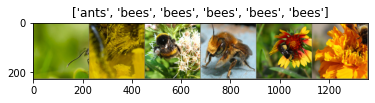

In [27]:
# 批量制作网格
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# 4. 训练模型

写一个通用函数来训练模型。 下面将说明： * 调整学习速度 * 保存最好的模型

下面的参数scheduler是一个来自torch.optim.lr_scheduler学习速率调整类的对象(LR scheduler object)。

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 每个epoch都有一个训练和验证阶段
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # 迭代数据.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 零参数梯度
                optimizer.zero_grad()

                # 前向
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 后向+仅在训练阶段进行优化
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 统计
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 深度复制mo
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 加载最佳模型权重
    model.load_state_dict(best_model_wts)
    return model

# 5. 可视化模型的预测结果

In [ ]:
#一个通用的展示少量预测图片的函数
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# 6.场景1：微调ConvNet

加载预训练模型并恢复完全连接的图层。

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 观察所有参数都正在优化
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 每7个epochs衰减LR通过设置gamma=0.1
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# 训练和评估模型

（1）训练模型该过程在CPU上大约需要15-25分钟，但在GPU上不到很少一分钟。

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.6178 Acc: 0.6885
val Loss: 0.3963 Acc: 0.8366

Epoch 1/24
----------
train Loss: 0.5395 Acc: 0.7664
val Loss: 0.2107 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.3462 Acc: 0.8443
val Loss: 0.2689 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.3705 Acc: 0.8156
val Loss: 0.2510 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.4820 Acc: 0.8279
val Loss: 0.2448 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.6010 Acc: 0.7705
val Loss: 0.5478 Acc: 0.8301

Epoch 6/24
----------
train Loss: 0.4416 Acc: 0.8402
val Loss: 0.1916 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3428 Acc: 0.8730
val Loss: 0.1916 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.2518 Acc: 0.8811
val Loss: 0.1896 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.2964 Acc: 0.8811
val Loss: 0.1659 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3071 Acc: 0.8730
val Loss: 0.1663 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.2231 Acc: 0.9221
val Loss: 0.1772 Acc: 0.9542

Epoch 12/24
----------
t

（2）模型评估效果可视化

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


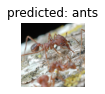

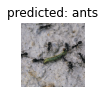

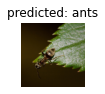

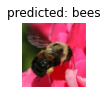

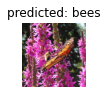

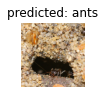

In [ ]:
visualize_model(model_ft)

# 7.场景2：ConvNet作为固定特征提取器

通过恢复requires_grad == Falsebackward()来冰冻的参数，这样在后面传播（）的时候他们的就不会被计算了。

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# 锻炼和评估

（1）训练模型在上，与之前的一个场景模拟，这将占用大约 CPU 的时间，因为不需要大量计算网络。但需要计算讨论。

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.5892 Acc: 0.6680
val Loss: 0.2477 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.4297 Acc: 0.8033
val Loss: 0.2102 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.3539 Acc: 0.8443
val Loss: 0.2437 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.6109 Acc: 0.7705
val Loss: 0.5417 Acc: 0.7908

Epoch 4/24
----------
train Loss: 0.5094 Acc: 0.7705
val Loss: 0.1865 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.4560 Acc: 0.7992
val Loss: 0.3445 Acc: 0.8627

Epoch 6/24
----------
train Loss: 0.4469 Acc: 0.8361
val Loss: 0.1781 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3408 Acc: 0.8402
val Loss: 0.1839 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3618 Acc: 0.8320
val Loss: 0.1869 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.3271 Acc: 0.8443
val Loss: 0.1715 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.4458 Acc: 0.8033
val Loss: 0.1881 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.4160 Acc: 0.8402
val Loss: 0.1713 Acc: 0.9477

Epoch 12/24
----------
t

（2）模型评估效果可视化

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


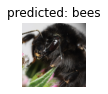

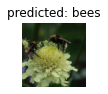

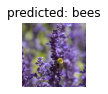

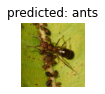

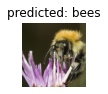

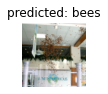

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()